# import

In [1]:
import tensorflow as tf
from PIL import Image
import os, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# configuration

In [24]:
TRAIN_DIR = '../input_feature/clean_3'
EVAL_DIR = '../input_feature/clean_3_eval'
IMAGE_DIR = '../imgs/clean_2_eval_augmented/'
# MASK_DIR = '../imgs/clean_1_mask/'

file_names_train = next(os.walk(TRAIN_DIR))[2]
file_names_eval = next(os.walk(EVAL_DIR))[2]
for i in range(len(file_names_train)):
    file_names_train[i] = os.path.join(TRAIN_DIR, file_names_train[i])
for i in range(len(file_names_eval)):
    file_names_eval[i] = os.path.join(EVAL_DIR, file_names_eval[i])



BUFFER_SIZE = 100

eval_ratio = 0
n_eval = 100
n_train = 532
n_filters = 48
BATCH_SIZE = 50

tf.random.set_random_seed(0)

n_batch = int(n_train / BATCH_SIZE)


input_activation = tf.nn.relu
kernel_initializer = tf.truncated_normal_initializer(stddev=0.1)
learning_rate = 0.0025
EPOCHS = 50
display_epoch = 10
THRESHOLD = 0.5

print('** file_names **')
print(file_names_train)
print(file_names_eval)
print('BUFFER_SIZE: ', BUFFER_SIZE)
print('TRAIN SIZE: ', n_train)
print('EVAL SIZE: ', n_eval)

** file_names **
['../input_feature/clean_3/clean_3_augmented.TFRecord']
['../input_feature/clean_3_eval/clean_3_eval_augmented.TFRecord']
BUFFER_SIZE:  100
TRAIN SIZE:  532
EVAL SIZE:  100


In [25]:
def map_func(serialized):
	# mapping 함수를 짜주고, map메소드의 Parameter로 사용
    features = {
        'file_name':tf.VarLenFeature(dtype=tf.string),
        'feature': tf.FixedLenFeature([], dtype=tf.string), # binary형태로 읽어야 하며
        'label': tf.FixedLenFeature([], dtype=tf.string) # string이기도 함!
    }
    features = tf.parse_single_example(serialized=serialized,
                                      features=features)
    
	# 보통 reshape의 전처리가 추가 되는 편
    file_name = features['file_name']
    feature = tf.reshape(tf.decode_raw(features['feature'], tf.float64), [8*3*3, 1]) # 기본이 64 비트 
    label = tf.reshape(tf.decode_raw(features['label'], tf.int64), [24]) # 기본 64 비트
    return file_name, feature, label # 필수

# Dataset


In [26]:
dataset = tf.data.TFRecordDataset(file_names_train).map(map_func)
dataset_eval = tf.data.TFRecordDataset(file_names_eval).map(map_func)

iterator_train = dataset.shuffle(BUFFER_SIZE).batch(n_train).make_one_shot_iterator()
iterator_train_batch = dataset.shuffle(BUFFER_SIZE).batch(n_train).repeat().make_one_shot_iterator()
iterator_eval = dataset_eval.shuffle(n_eval).batch(n_eval).repeat().make_one_shot_iterator()

file_name_train_batch, x_train_batch, y_train_batch = iterator_train_batch.get_next()
file_name_eval, x_eval, y_eval = iterator_eval.get_next()

with tf.Session() as sess:
    file_name_train, x_train, y_train = sess.run(iterator_train.get_next())
    file_name_eval, x_eval, y_eval = sess.run(iterator_eval.get_next())

In [27]:
x_train.shape, x_eval.shape

((532, 72, 1), (100, 72, 1))

In [28]:
for i in range(8):
    print(file_name_train[1][i], file_name_eval[1][i])

b'class_238_r_+_9.jpg' b'class_216_r_+_14.jpg'
b'class_58_r_-_4.jpg' b'class_216_-_9.jpg'
b'class_54_+_9.jpg' b'class_56_r_-_9.jpg'
b'class_30_+_4.jpg' b'class_56_r_-_14.jpg'
b'class_230_r_+_14.jpg' b'class_232_r_-_9.jpg'
b'class_102_-_14.jpg' b'class_141_-_14.jpg'
b'class_55_r_+_4.jpg' b'class_232_-_14.jpg'
b'class_234_+_14.jpg' b'class_18_r_-_14.jpg'


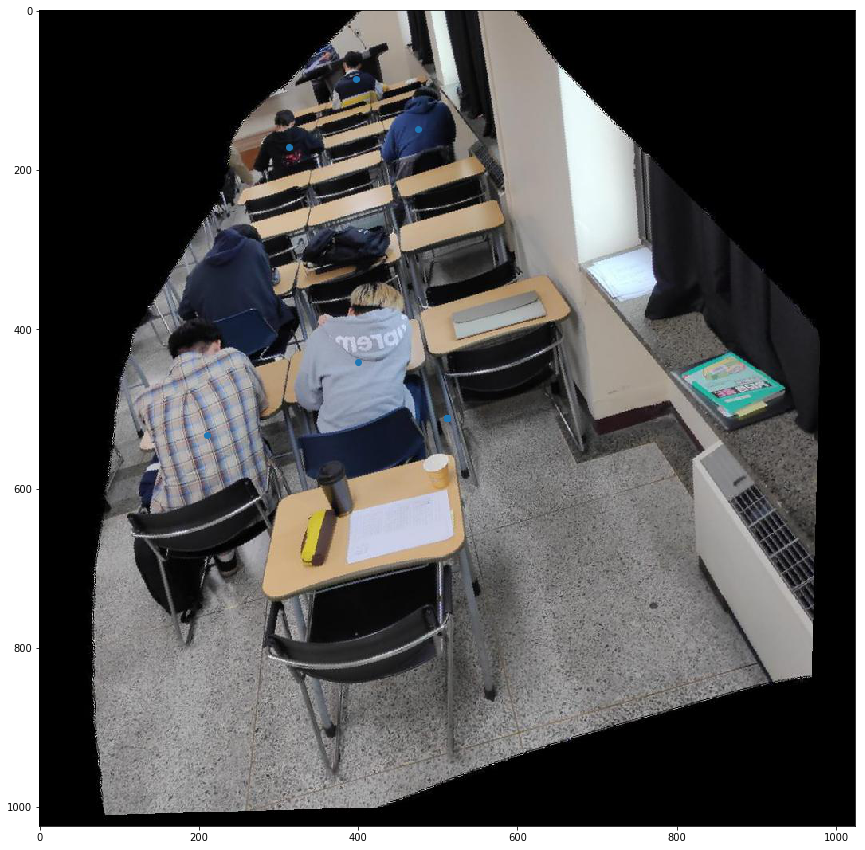

In [29]:
def show_image(file_name, x_eval):
    image = Image.open(os.path.join(IMAGE_DIR, file_name))
    aa = x_eval
    aa = aa.reshape((24,3))
    fig = plt.figure(figsize=(15,15))
    plt.imshow(image) 
    plt.scatter(y=aa[:,0] + 512, x=aa[:,1] + 512)
    # plt.scatter(y=aa[:,4], x=aa[:,5])
    # plt.scatter(y=1024 - aa[:,6], x=1024-aa[:,7])
    plt.show()
    
show_image(file_name_eval[1][0].decode('utf-8'), x_eval[0])

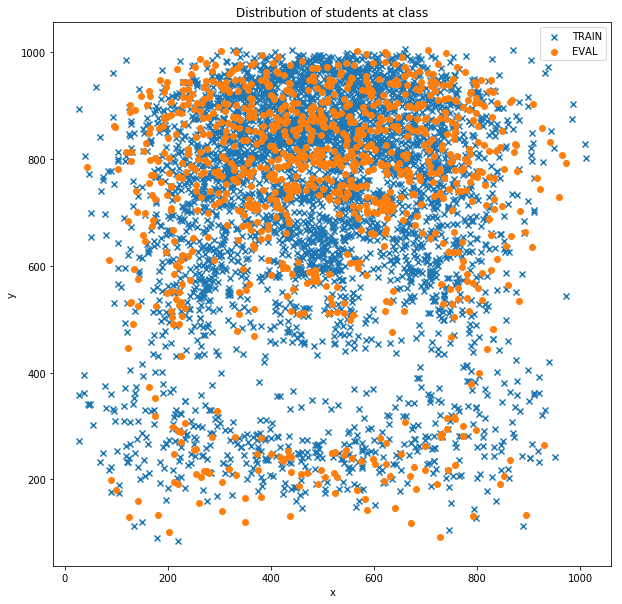

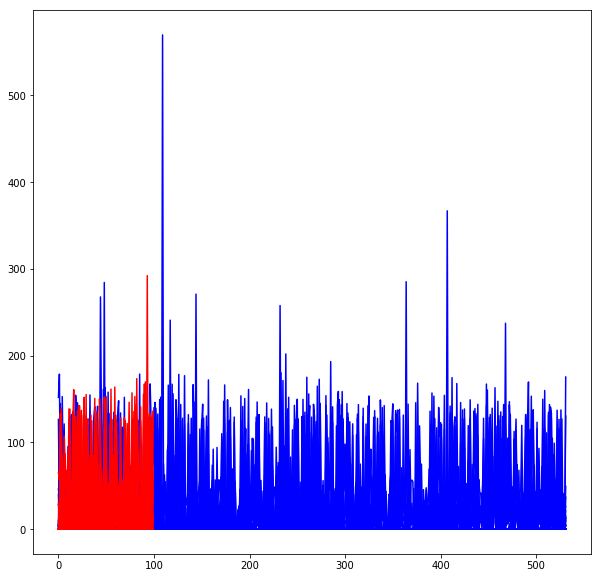

In [30]:
x_train = x_train.reshape((-1,24,3))
x_eval = x_eval.reshape((-1,24,3))
fig = plt.figure(figsize=(10,10))
plt.scatter(y=-x_train[:,:, 0]+512, x=x_train[:,:, 1]+512, marker='x', label='TRAIN')
plt.scatter(y=-x_eval[:,:, 0]+512, x=x_eval[:,:, 1]+512, marker='o', label='EVAL')
plt.title('Distribution of students at class')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# plt.scatter(x=x_eval[:,:, 0], y=x_eval[:,:, 1])
plt.show()
# 사진의 특성에 따른 밀집도
fig = plt.figure(figsize=(10,10))
plt.plot(x_train[:,:,2], color='b')
plt.plot(x_eval[:,:,2], color='r')
plt.show()

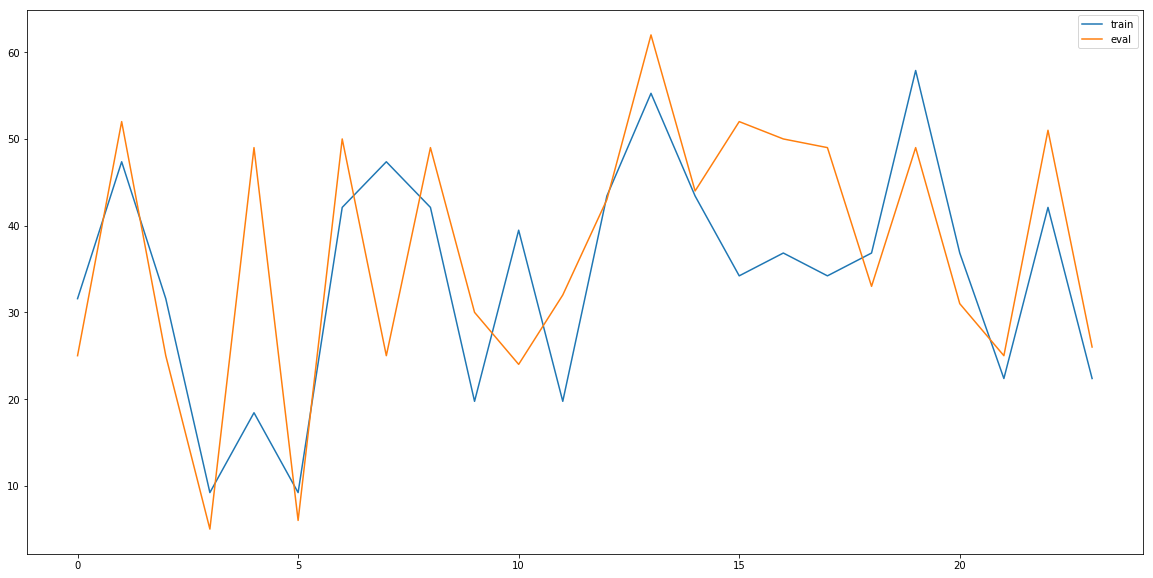

In [16]:
fig = plt.figure(figsize=(20,10))
# plt.plot(x_train[:10,1], label='x')
# plt.plot(x_train[:10,2], label='y')
plt.plot(np.mean(y_train, axis=0) * 100, label='train')
plt.plot(np.mean(y_eval, axis=0) * 100, label='eval')
plt.legend()
plt.show()
# 고정 된 자리의 편향을 완전히 외우는 건 아니다.
# 자리 별 confusion matrix, -> 한계가 있거나 없거나.

# Model

In [17]:

# layers
input_x = tf.placeholder(dtype=tf.float64, shape=[None, 8*3*3, 1], name='input_x')
input_y = tf.placeholder(dtype=tf.int64, shape=[None, 24], name='input_y')

hidden_layer_input = tf.layers.conv1d(input_x, filters=n_filters, 
                                      kernel_size=3, strides=3, 
                                      activation=input_activation, use_bias=True,
                                      kernel_initializer=kernel_initializer,
                                      kernel_regularizer=None)
hidden_layer = tf.reduce_sum(hidden_layer_input, axis=1)
hidden_layer_out = tf.layers.dense(hidden_layer, 24,
                                   activation=None,
                                  kernel_initializer=kernel_initializer,
                                  kernel_regularizer=None)

# loss
loss = tf.losses.sigmoid_cross_entropy(input_y, hidden_layer_out)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# predictiont
hidden_layer_out_sigmoid = tf.sigmoid(hidden_layer_out)
predictions = tf.reshape(hidden_layer_out_sigmoid, shape=[-1])
predictions = tf.greater_equal(predictions, tf.constant(THRESHOLD, shape=[1], dtype=tf.float64))
predictions = tf.cast(predictions, dtype=tf.int64, name='predictions')
labels = tf.reshape(input_y, shape=[-1], name='labels')
equals = tf.cast(tf.equal(labels, predictions), dtype=tf.float32)
accuracy = tf.reduce_mean(equals, axis=0)

print(input_x)
print(hidden_layer_input)
print(hidden_layer)
print(hidden_layer_out)
print(predictions)
print(accuracy)

Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Tensor("input_x:0", shape=(?, 72, 1), dtype=float64)
Tensor("conv1d/Relu:0", shape=(?, 24, 48), dtype=float64)
Tensor("Sum:0", shape=(?, 48), dtype=float64)
Tensor("dense/BiasAdd:0", shape=(?, 24), dtype=float64)
Tensor("predictions:0", shape=(?,), dtype=int64)
Tensor("Mean:0", shape=(), dtype=float32)


In [22]:
# confusion matrix function

def show_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
#     accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
#     print(accuracy)
#     precision = cm[1][1] / (cm[1][0] + cm[1][1])
#     print(precision)
#     recall = cm[0][0] / (cm[0][0] + cm[0][1])
#     print(recall)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=[0,1], yticklabels=[0,1],
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.3f'
    thresh = cm.max() - cm.min() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
# show_confusion_matrix(a, b)

# Train & Evaluate Model

*** TRAIN epoch: 0 ***
TRAIN loss: 6.67186 accuracy: 0.57245
EVAL loss: 11.87585 accuracy: 0.52667
*** TRAIN epoch: 10 ***
TRAIN loss: 0.56839 accuracy: 0.73120
EVAL loss: 0.78654 accuracy: 0.67014
*** TRAIN epoch: 20 ***
TRAIN loss: 0.46900 accuracy: 0.78352
EVAL loss: 0.67766 accuracy: 0.68167
*** TRAIN epoch: 30 ***
TRAIN loss: 0.42003 accuracy: 0.80843
EVAL loss: 0.55923 accuracy: 0.72222
*** TRAIN epoch: 40 ***
TRAIN loss: 0.40189 accuracy: 0.82018
EVAL loss: 0.67394 accuracy: 0.69958
*** TRAINING DONE ***
time: 17.02s
EVAL loss: 0.58882 accuracy: 0.74306


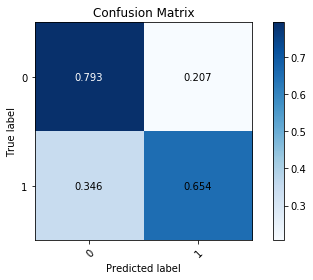

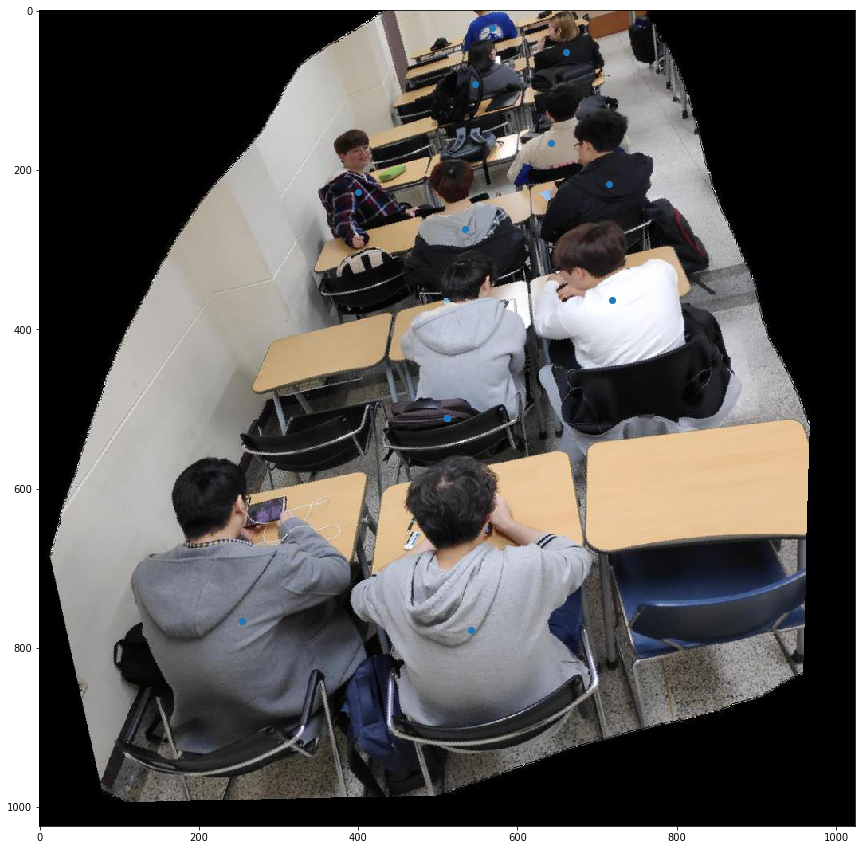

*** 예측 한 라벨 ***
[[0 0 1]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [1 1 0]
 [0 1 1]
 [0 1 1]
 [1 1 0]]


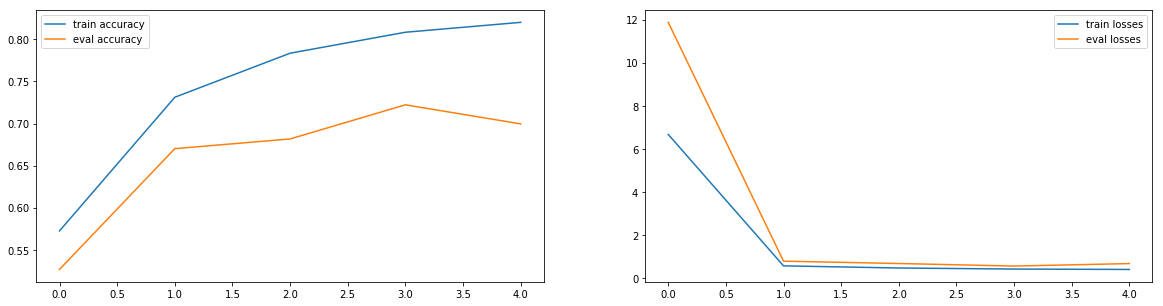

In [31]:
accuracy_train = []
accuracy_eval = []
losses_train = []
losses_eval = []
file_name_eval, x_eval, y_eval = iterator_eval.get_next()


early_stop = False
with tf.Session() as sess:
    tic = time.time()
    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):
        for _ in range(n_batch):
            _file_name, _x, _y = sess.run([file_name_train_batch, x_train_batch, y_train_batch])
            feed_dict = {input_x: _x,
                        input_y: _y}
            _, _accuracy, _loss = sess.run([train_op, accuracy, loss], feed_dict=feed_dict)
            
        if epoch % display_epoch == 0:
            _loss, _accuracy, _predictions, _labels, _equals = sess.run([loss, accuracy, predictions, labels, equals],
                                                                       feed_dict)
            print('*** TRAIN epoch: %1d ***'%(epoch))
            print('TRAIN loss: %5.5f accuracy: %5.5f' % (_loss, _accuracy))
            accuracy_train.append(_accuracy)
            losses_train.append(_loss)
            train_loss = _loss
#             show_confusion_matrix(_labels, _predictions)

            _file_name, _x, _y = sess.run([file_name_eval, x_eval, y_eval])
            feed_dict = {input_x: _x,
                        input_y: _y}
            _loss, _accuracy, _predictions, _labels, _equals = sess.run([loss, accuracy, predictions, labels, equals],
                                                                       feed_dict)
            print('EVAL loss: %5.5f accuracy: %5.5f' % (_loss, _accuracy))
#             show_confusion_matrix(_labels, _predictions)
            accuracy_eval.append(_accuracy)
            losses_eval.append(_loss)
            if train_loss < 0.4 and _loss < 0.45:
                early_stop = True
                break
        if early_stop:
            break
    
    # 학습 종료
    print('*'*3,'TRAINING DONE', '*'*3)
    toc = time.time()
    print('time: %.2fs'%(toc - tic))

    _file_name, _x, _y = sess.run([file_name_eval, x_eval, y_eval])
    feed_dict = {input_x: _x,
                input_y: _y}
    _loss, _accuracy, _predictions, _labels, _equals = sess.run([loss, accuracy, predictions, labels, equals],
                                                               feed_dict)
    print('EVAL loss: %5.5f accuracy: %5.5f' % (_loss, _accuracy))
    show_confusion_matrix(_labels, _predictions)
    show_image(_file_name[1][0].decode('utf-8'), _x[0])
    print('*** 예측 한 라벨 ***')
    print(_predictions.reshape((-1,8,3))[0])
    
# PLOT LOSS AND ACCURACY
fig = plt.figure(figsize=(20,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(accuracy_train, label='train accuracy')
ax1.plot(accuracy_eval, label='eval accuracy')
ax1.legend()
ax2.plot(losses_train, label='train losses')
ax2.plot(losses_eval, label='eval losses')
ax2.legend()
plt.show()